In [6]:
import warnings

warnings.filterwarnings(action='ignore')

from shutil import copyfileobj
from six.moves import urllib
from sklearn import datasets
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def fetch_mnist(data_home=None):
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    data_home = datasets.get_data_home(data_home=data_home)
    
    data_home = os.path.join(data_home, 'mldata')
    if not os.path.exists(data_home):
        os.makedirs(data_home)
    mnist_save_path = os.path.join(data_home, "mnist-original.mat")
    if not os.path.exists(mnist_save_path):
        mnist_url = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_save_path, "wb") as matlab_file:
            copyfileobj(mnist_url, matlab_file)

fetch_mnist()

In [7]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [10]:
X,y = mnist["data"], mnist["target"]

print("train data : ",X.shape)
print("label data : ",y.shape)

train data :  (70000, 784)
label data :  (70000,)


5.0


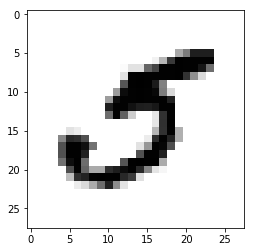

In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

index = 36000

some_digit = X[index]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")

print(y[index])

In [12]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [13]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index], y_train[shuffle_index]

In [15]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [16]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(max_iter=5, random_state=42)
sgd.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [17]:
sgd.predict([some_digit])

array([ True])

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9641
0.9696
0.9662


In [25]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.9641, 0.9696, 0.9662])

In [27]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [29]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.90805, 0.9092 , 0.9117 ])

In [30]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd,X_train,y_train_5,cv=2)

In [34]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53343,  1236],
       [ 1067,  4354]], dtype=int64)

In [40]:
from sklearn.metrics import precision_score,recall_score

print('precision : ',precision_score(y_train_5,y_train_pred))
print("recall : ", recall_score(y_train_5, y_train_pred))

precision :  0.7788908765652952
recall :  0.803172846338314


In [41]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7908455181182454

In [42]:
y_scores = sgd.decision_function([some_digit])
y_scores

array([119741.59626309])

In [43]:
threshold=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [44]:
threshold=200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [45]:
y_scores = cross_val_predict(sgd,X_train,y_train_5,cv=3,method="decision_function")


In [46]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

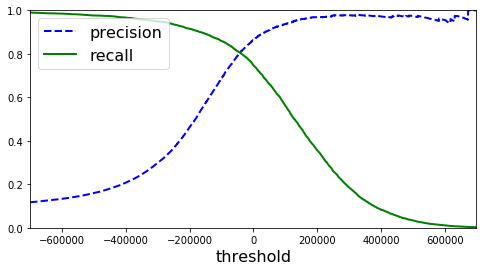

In [47]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="recall", linewidth=2)
    plt.xlabel("threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

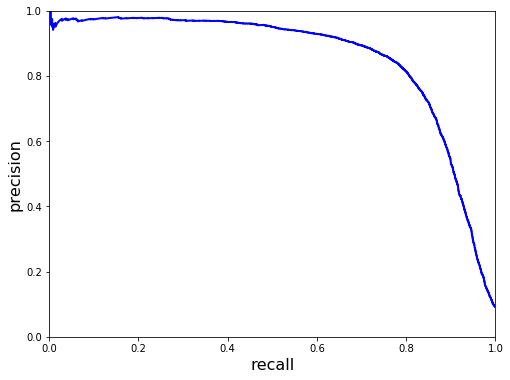

In [49]:
def plot_precison_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("recall", fontsize=16)
    plt.ylabel("precision", fontsize=16)
    plt.axis([0,1,0,1])
    
plt.figure(figsize=(8,6))
plot_precison_vs_recall(precisions, recalls)
plt.show()

In [54]:
y_train_pred_90 = (y_scores > 700000)

In [55]:
precision_score(y_train_5,y_train_pred_90)

1.0

In [56]:
recall_score(y_train_5,y_train_pred_90)

0.002951484965873455

In [57]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

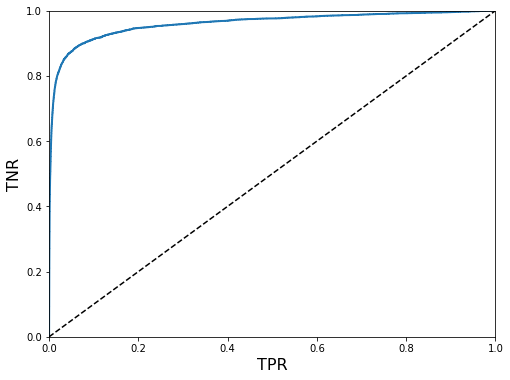

In [58]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('TPR', fontsize=16)
    plt.ylabel('TNR', fontsize=16)
    
plt.figure(figsize=(8,6))
plot_roc_curve(fpr,tpr)
plt.show()

In [59]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9606638135956276

In [60]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest, X_train, y_train_5, cv=3, method="predict_proba")

In [61]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

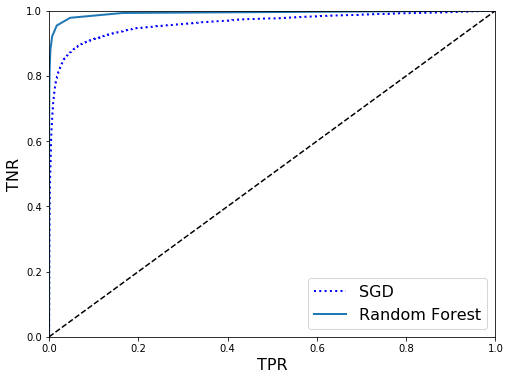

In [62]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [63]:
sgd.fit(X_train,y_train)
sgd.predict([some_digit])

array([5.])

In [64]:
some_digit_scores = sgd.decision_function([some_digit])
some_digit_scores

array([[ -96584.09396461, -481018.76053698, -509133.03690895,
        -309679.44157235, -515612.97071302,   80897.39735862,
        -728127.61718895, -372955.25146687, -501175.50172042,
        -749135.07444755]])

In [65]:
np.argmax(some_digit_scores)

5

In [66]:
sgd.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [67]:
sgd.classes_[5]

5.0

In [69]:
from sklearn.multiclass import OneVsOneClassifier
ovo=OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo.fit(X_train,y_train)
ovo.predict([some_digit])

array([5.])

In [70]:
len(ovo.estimators_)

45

In [71]:
forest.fit(X_train, y_train)
forest.predict([some_digit])

array([5.])

In [72]:
forest.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.2, 0. , 0.7, 0. , 0.1, 0. , 0. ]])

In [73]:
cross_val_score(sgd,X_train,y_train,cv=3,scoring="accuracy")

array([0.86427714, 0.86784339, 0.84537681])

In [75]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd,X_train_scaled,y_train,cv=3,scoring='accuracy')

array([0.91006799, 0.91054553, 0.90843627])

In [76]:
y_train_pred=cross_val_predict(sgd,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5741,    4,   20,    9,   10,   42,   46,    9,   39,    3],
       [   1, 6480,   44,   21,    6,   45,    8,   12,  113,   12],
       [  52,   37, 5313,  111,   79,   22,   99,   59,  170,   16],
       [  44,   40,  124, 5352,    3,  235,   37,   61,  138,   97],
       [  21,   28,   39,    8, 5348,   10,   61,   42,   85,  200],
       [  70,   47,   33,  192,   65, 4593,  112,   33,  189,   87],
       [  29,   22,   42,    2,   41,   93, 5637,    9,   43,    0],
       [  19,   17,   69,   32,   52,   12,    5, 5826,   18,  215],
       [  50,  154,   69,  156,   13,  159,   63,   28, 5035,  124],
       [  45,   33,   30,   83,  146,   41,    2,  232,   81, 5256]],
      dtype=int64)

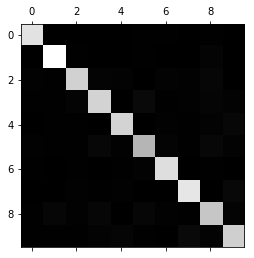

In [77]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

In [78]:
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx=conf_mx / row_sums

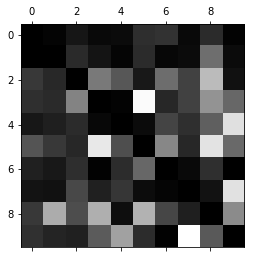

In [79]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

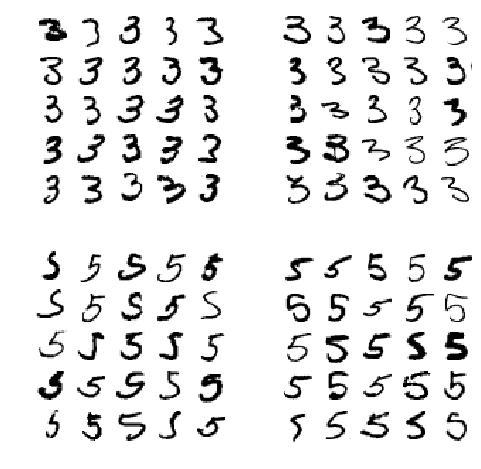

In [81]:
def plot_digits(instances, images_per_row=10, **options):
    size =28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empth = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empth)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
    
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [82]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn = KNeighborsClassifier()
knn.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [85]:
knn.predict([some_digit])

array([[False,  True]])

In [91]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

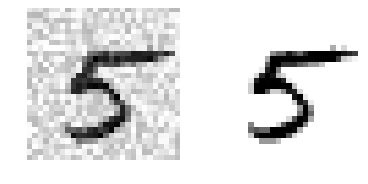

In [92]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
              interpolation="nearest")
    plt.axis("off")

some_index= 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

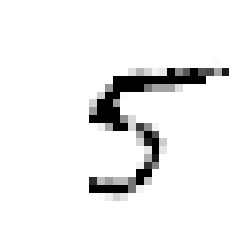

In [93]:
knn.fit(X_train_mod, y_train_mod)
clean_digit = knn.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

## 분류(Classification)
1. 학습 / 테스트 분리
2. 교차검증의 fold를 비슷하게 하기위해 섞는다.
3. 값이 5일때 true 훈련 진행

## 오차행렬(confusion matrix)
TN : 5가 아닌 이미지를 5가 아니라고 분류했다. (True Negative)
FN : 5인 이미지를 5가 아니라고 분류했다. (False Negative)
FP : 5가 아닌 이미지를 5라고 분류했다. (Fasle Positive)
TP : 5인 이미지를 5라고 분류했다.(True Positive)

오차행렬 자체도 많은 정보를 제공해주지만 가끔 더 요약된 지표가 필요하다. 

## 정밀도 / 재현율 trade-off

정밀도가 높으면 재현율이 줄고, 재현율이 높으면 정밀도가 줄어든다.

##결정 함수(decision function)
결정 함수를 사용해서 각 샘플의 점수를 계산한다.
이 점수가 임계 값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당한다.

## ROC 곡선
이진 분류에서 널리 사용하는 도구다.
정밀도/재현율 곡선과 비슷하지만, 
거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)을 나타낸다. 

# FPR : 양성으로 잘못 분류된 음성 샘플의 비율(1 - TNR)
# TNR : 특이도

# ROC 곡선 : 재현율에 대한 1 – TNR(특이도) 그래프

## 다중 분류

이제까지 5인지 아닌지 구분하는 이진 분류였다면 
이번에는 0 ~ 9를 분류하는 다중 분류를 진행한다.


## 일대다(OvA) : 이진 분류기 10개를 훈련시켜서 다중 분류기를 만드는 방법이 있다. 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택

## 일대일(OvO) : 각 숫자의 조합(0,1구별, 0,2구별 …)마다 이진 분류기를 훈련시키는 방법이 있다. 45개의 분류기가 필요하다.

SVM 같은 경우는 큰 학습데이터를 몇 개의 분류기로 훈련하는 것보다 작은 학습데이터를 많은 분류기로 훈련하는 것이 좋다.(OvO 선호)

하지만 대부분 OvA를 선호한다.
